In [24]:
from rdkit import Chem
from rdkit.Chem import AllChem, Lipinski
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt

In [9]:
smile="Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1"

In [10]:
mol = Chem.MolFromSmiles(smile)
nums_atom = mol.GetNumAtoms()
u, v = [], []
for bond in mol.GetBonds():
    begin = bond.GetBeginAtom()
    end = bond.GetEndAtom()
    u.append(begin.GetIdx())
    v.append(end.GetIdx())

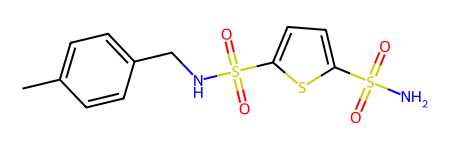

In [11]:
mol

In [19]:
nums_atom

21

In [20]:
def create_hypergraph_from_mol():
    # Create hyperedges based on atom neighborhoods
    hyperedges = []
    for atom_idx in range(nums_atom):
        # Get neighbors for each atom
        atom = mol.GetAtomWithIdx(atom_idx)
        neighbors = [n.GetIdx() for n in atom.GetNeighbors()]
        neighbors.append(atom_idx)
        hyperedges.append(set(neighbors))

    # Create hypergraph
    H = hnx.Hypergraph(dict(enumerate(hyperedges)))

    # Plot
    plt.figure(figsize=(12, 8))
    hnx.draw(H,
             with_node_labels=True,
             with_edge_labels=False)
    plt.title('Molecule Hypergraph')
    plt.show()

    return H

def create_improved_functional_hypergraph_from_mol():
    # Hyperedges für Ringe und funktionale Gruppen
    hyperedges = []

    # 1) Ring‐Hyperedges
    rings = mol.GetRingInfo()
    for ring_atoms in rings.AtomRings():
        hyperedges.append(set(ring_atoms))

    # 2) Funktionsgruppen‐Hyperedges (S, N, O mit ihren Nachbarn)
    for atom_idx in range(nums_atom):
        atom = mol.GetAtomWithIdx(atom_idx)
        if atom.GetSymbol() in ['S', 'N', 'O']:
            group = set([atom_idx] + [nbr.GetIdx() for nbr in atom.GetNeighbors()])
            if len(group) > 1:
                hyperedges.append(group)

    # 3) Rest‐Hyperedge: alle Atome, die bisher in KEINEM Hyperedge vorkommen
    all_atoms = set(range(nums_atom))
    covered = set().union(*hyperedges) if hyperedges else set()
    residual = all_atoms - covered
    if len(residual) > 1:
        hyperedges.append(residual)

    # Hypergraph aufbauen und zeichnen
    H = hnx.Hypergraph(dict(enumerate(hyperedges)))
    plt.figure(figsize=(12, 8))
    hnx.draw(H, with_node_labels=True, with_edge_labels=False)
    plt.title('Verbesserter funktionaler Hypergraph der Drug-Struktur')
    plt.show()

    return H


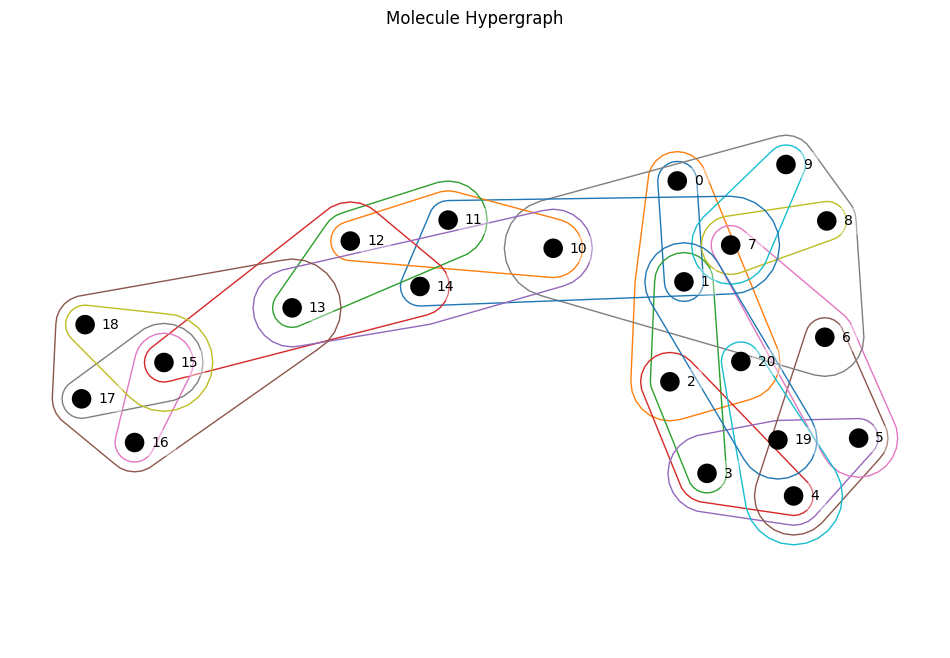

In [21]:
H = create_hypergraph_from_mol()

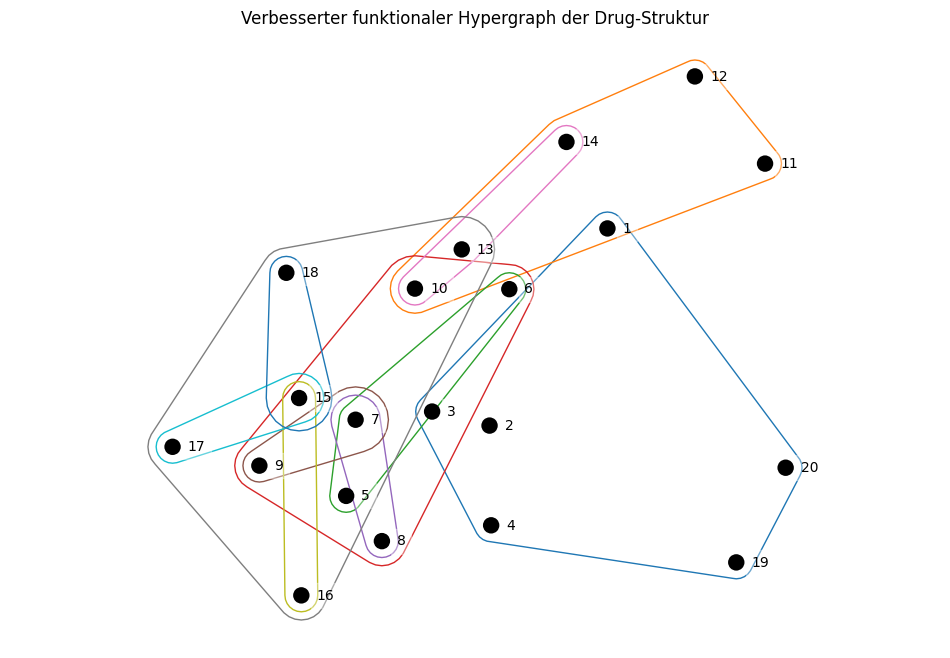

In [23]:
H_function = create_improved_functional_hypergraph_from_mol()

In [27]:
def create_enhanced_hypergraph_from_mol(mol):
    """
    Erzeugt einen Hypergraphen mit
      - Ringen
      - funktionalen Gruppen (S, N, O + Nachbarn)
      - Rest
      - Bindungs-Typen
      - Rotatable-Torsions (4-Atom-Gruppen)
      - Gasteiger-Partial-Charges
    und nutzt 3D-Embedding + UFF-Optimierung.
    """
    nums_atom = mol.GetNumAtoms()
    hyperedges = []

    # (1) 3D-Konformer generieren
    mol3d = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol3d, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol3d)
    conf = mol3d.GetConformer()

    # (2) Ring-Hyperedges
    rings = mol.GetRingInfo().AtomRings()
    for ring in rings:
        hyperedges.append(set(ring))

    # (3) Funktionale Gruppen (S, N, O + Nachbarn)
    for idx in range(nums_atom):
        sym = mol.GetAtomWithIdx(idx).GetSymbol()
        if sym in ('S','N','O'):
            ngh = [n.GetIdx() for n in mol.GetAtomWithIdx(idx).GetNeighbors()]
            group = set(ngh + [idx])
            if len(group) > 1:
                hyperedges.append(group)

    # (4) Rest-Hyperedge
    covered = set().union(*hyperedges) if hyperedges else set()
    rest = set(range(nums_atom)) - covered
    if len(rest) > 1:
        hyperedges.append(rest)

    # (5) Bindungs-Typ-Hyperedges
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        # einzelne 2-Atom-Hyperedge spiegelt den Bindungstyp wider
        hyperedges.append({i, j})

    # (6) Rotations-/Torsions-Hyperedges
    rot_smarts = Chem.MolFromSmarts('[!$(*#*)&!D1]-!@[!$(*#*)&!D1]')
    for (i, j) in mol.GetSubstructMatches(rot_smarts):
        # Finde jeweils einen Nachbarn k ≠ j und l ≠ i
        nbrs_i = [n.GetIdx() for n in mol.GetAtomWithIdx(i).GetNeighbors() if n.GetIdx()!=j]
        nbrs_j = [n.GetIdx() for n in mol.GetAtomWithIdx(j).GetNeighbors() if n.GetIdx()!=i]
        if nbrs_i and nbrs_j:
            k, l = nbrs_i[0], nbrs_j[0]
            hyperedges.append({k, i, j, l})

    # (7) Partial Charges (Gasteiger)
    AllChem.ComputeGasteigerCharges(mol)
    pos = {idx for idx in range(nums_atom)
           if float(mol.GetAtomWithIdx(idx).GetProp('_GasteigerCharge')) >  0.1}
    neg = {idx for idx in range(nums_atom)
           if float(mol.GetAtomWithIdx(idx).GetProp('_GasteigerCharge')) < -0.1}
    if len(pos) > 1: hyperedges.append(pos)
    if len(neg) > 1: hyperedges.append(neg)

    # Hypergraph aufbauen und zeichnen
    print(len(hyperedges))
    H = hnx.Hypergraph({i: edge for i, edge in enumerate(hyperedges)})
    plt.figure(figsize=(14, 10))
    hnx.draw(H, with_node_labels=True, with_edge_labels=False)
    plt.title('Erweiterter Hypergraph mit Topologie, 3D & Charges')
    plt.show()

    return H

40


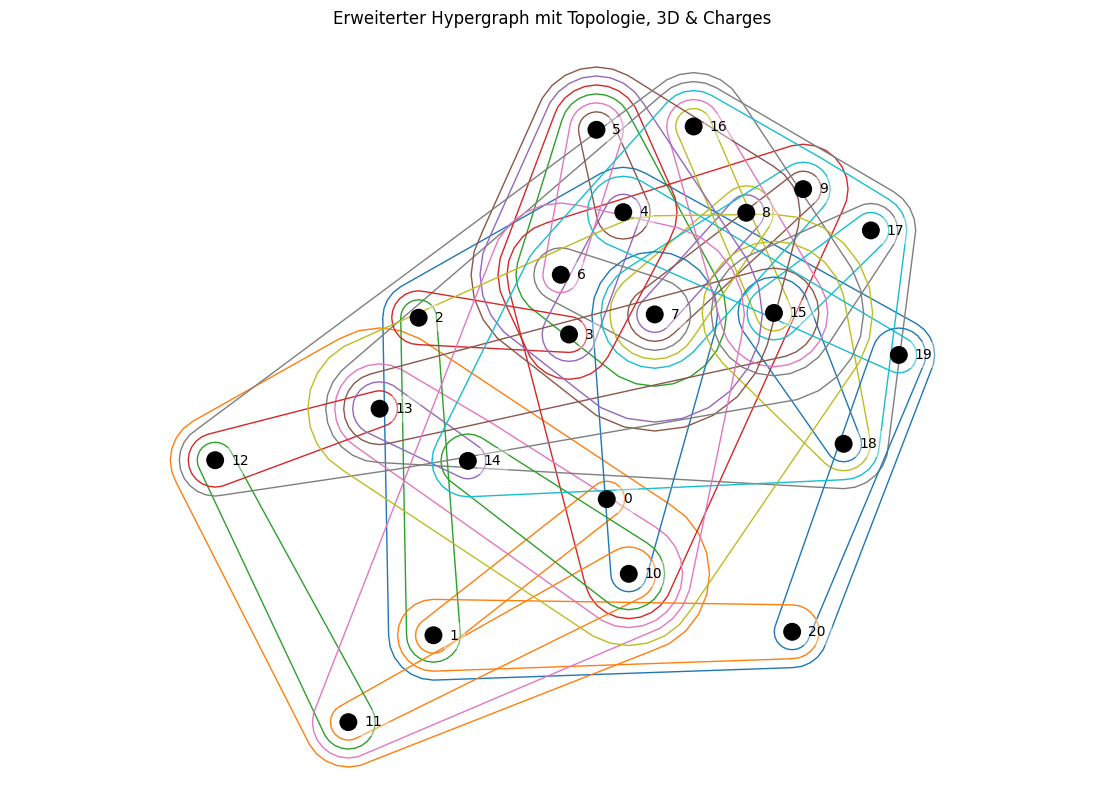

In [28]:
H = create_enhanced_hypergraph_from_mol(mol)

In [31]:
def create_minimal_hypergraph(mol):
    """
    Minimaler Hypergraph mit
      1) Ring‐Hyperedges
      2) Ein Hyperedge für alle Heteroatome (S, N, O)
      3) Hyperedges für positive und negative Regionen (Gasteiger‐Ladungen)
      4) Ein Rest‐Hyperedge für das reine C/H‐Gerüst
    """
    nums_atom = mol.GetNumAtoms()
    hyperedges = []

    # 1) Ringe
    for ring in mol.GetRingInfo().AtomRings():
        hyperedges.append(set(ring))

    # 2) Alle Heteroatome in EINEM Hyperedge
    hetero = {atom.GetIdx()
              for atom in mol.GetAtoms()
              if atom.GetSymbol() in ('S','N','O')}
    if len(hetero) > 1:
        hyperedges.append(hetero)

    # 3) Partial Charges
    AllChem.ComputeGasteigerCharges(mol)
    pos = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) >  0}
    neg = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) <  0}
    if len(pos) > 1:
        hyperedges.append(pos)
    if len(neg) > 1:
        hyperedges.append(neg)

    # 4) Rest‐Gerüst (C/H‐Atome)
    covered = set().union(*hyperedges) if hyperedges else set()
    rest = set(range(nums_atom)) - covered
    if len(rest) > 1:
        hyperedges.append(rest)

    # Aufbau & Plot
    print(len(hyperedges))
    H = hnx.Hypergraph({i: e for i, e in enumerate(hyperedges)})
    plt.figure(figsize=(10, 6))
    hnx.draw(H, with_node_labels=True, with_edge_labels=False)
    plt.title('Minimaler Hypergraph')
    plt.show()

    return H


5


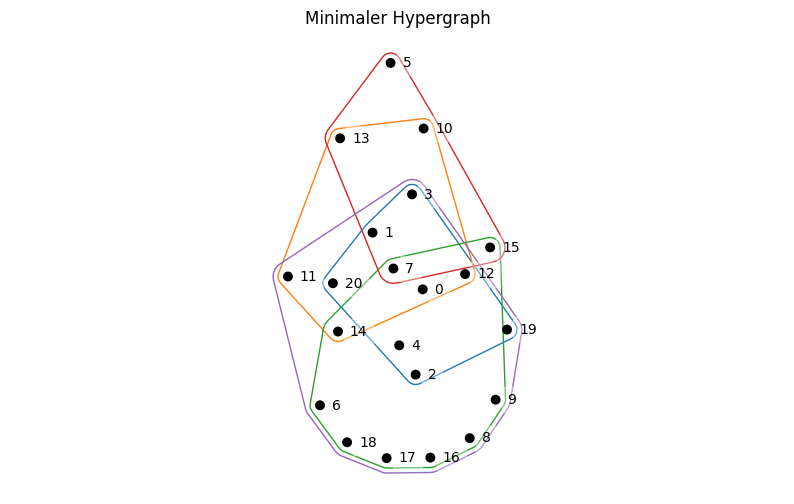

None hypernetx.classes.hypergraph.Hypergraph

In [32]:
create_minimal_hypergraph(mol)

In [38]:
def create_minimal_hypergraph_with_labels(mol):
    """
    Minimaler Hypergraph mit Beschriftungen:
      - Ringe (ring_0, ring_1, …)
      - Alle Heteroatome (hetero)
      - Positive/negative Regionen (pos_charge, neg_charge)
      - Rest-Gerüst (rest)
    Node-Labels: AtomSymbol+Index, Edge-Labels: Hyperedge-Namen
    """
    nums_atom = mol.GetNumAtoms()
    hyperedges = {}

    # 1) Ringe
    for i, ring in enumerate(mol.GetRingInfo().AtomRings()):
        hyperedges[f"ring_{i}"] = set(ring)

    # 2) Alle Heteroatome in einem Hyperedge
    hetero = {atom.GetIdx()
              for atom in mol.GetAtoms()
              if atom.GetSymbol() in ('S', 'N', 'O')}
    if len(hetero) > 1:
        hyperedges["hetero"] = hetero

    # 3) Partial Charges
    AllChem.ComputeGasteigerCharges(mol)
    pos = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) > 0}
    neg = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) < 0}
    if len(pos) > 1:
        hyperedges["pos_charge"] = pos
    if len(neg) > 1:
        hyperedges["neg_charge"] = neg

    # 4) Rest‐Gerüst (C/H‐Atome)
    covered = set().union(*hyperedges.values()) if hyperedges else set()
    rest = set(range(nums_atom)) - covered
    if len(rest) > 1:
        hyperedges["rest"] = rest

    # Hypergraph erstellen
    H = hnx.Hypergraph(hyperedges)

    # Node-Labels: z.B. "C3", "N7", …
    node_labels = {i: f"{mol.GetAtomWithIdx(i).GetSymbol()}{i}"
                   for i in range(nums_atom)}

    # Plot mit Node- und Edge-Labels
    plt.figure(figsize=(10, 6))
    hnx.draw(H,
             with_node_labels=True,
             node_labels=node_labels,
             with_edge_labels=True)
    plt.title('Minimaler Hypergraph mit Node- und Edge-Labels')
    plt.show()

    return H


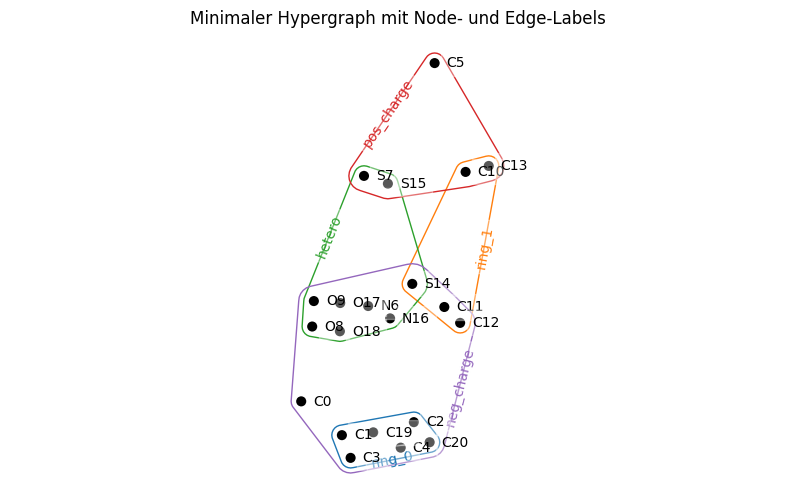

None hypernetx.classes.hypergraph.Hypergraph

In [41]:
create_minimal_hypergraph_with_labels(mol)